In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_images(line):
    """Returns centered, left and right images"""
    result = []
    for i in range(0, 3):
            source = line[i]
            filename = source.split('/')[-1]
            img_path = './data/IMG/%s' % filename
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            result.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
    return result
    

lines = []
with open ('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Ignore the header
lines = lines[1:]

In [ ]:
imgs = []
angles = []

for line in lines[1:]:
    angle = float(line[3])

    # Center
    center_source = line[0]
    center_fname = center_source.split('/')[-1]
    center_img_path = './samples-training/data/IMG/%s' % center_fname
    center_img = cv2.imread(center_img_path, cv2.IMREAD_COLOR)
    center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
    center_angle_correction = 0
    imgs.append(center_img)
    angles.append(angle)
    imgs.append(np.fliplr(center_img))
    angles.append(-angle)

    # Left
    left_source = line[1]
    left_fname = left_source.split('/')[-1]
    left_img_path = './samples-training/data/IMG/%s' % left_fname
    left_img = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    left_angle_correction = angle + 0.2
    imgs.append(left_img)
    angles.append(left_angle_correction)
    imgs.append(np.fliplr(left_img))
    angles.append(-left_angle_correction)
    
    # Right
    right_source = line[2]
    right_fname = right_source.split('/')[-1]
    right_img_path = './samples-training/data/IMG/%s' % right_fname
    right_img = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
    right_angle_correction = angle - 0.2
    imgs.append(right_img)
    angles.append(right_angle_correction)
    imgs.append(np.fliplr(right_img))
    angles.append(-right_angle_correction)
    

width = imgs[0].shape[1]
height = imgs[0].shape[0]
channels = imgs[0].shape[2]

In [2]:
import numpy as np
X_train = np.asarray(imgs)
y_train = np.asarray(angles)

plt.figure(figsize=(5,5))
plt.imshow(X_train[0])

NameError: name 'imgs' is not defined

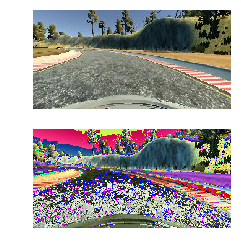

In [3]:
# Play with colors
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
%matplotlib inline

sample_img = X_train[0]
new_img = ((sample_img / 127.6) - 1)


fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)
ax[1].imshow(new_img, cmap='gray')

for a in ax:
    a.axis('off')

In [3]:
def load_image(img_full_path):
    name = img_full_path.split('/')[-1]
    path = './data/IMG/%s' % name
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

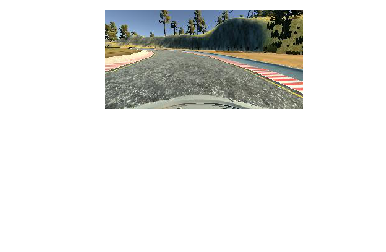

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

In [5]:
import sklearn.utils

CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.2
RIGHT_ANGLE_CORRECTION = -0.2

def generator(data, batch_size=128):
    num_samples = len(data)
    while True:
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_img = load_image(batch_sample[CENTER])
                left_img = load_image(batch_sample[LEFT])
                right_img = load_image(batch_sample[RIGHT])
                angle = float(batch_sample[ANGLE])
                
                images.append(center_img)
                angles.append(angle)
                
                images.append(left_img)
                angles.append(angle + LEFT_ANGLE_CORRECTION)
                
                images.append(right_img)
                angles.append(angle + RIGHT_ANGLE_CORRECTION)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [6]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

In [7]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
#model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# Resize the image to match the nvidia sizes.
model.add(Lambda(resize, input_shape=(160, 320, 3)))

# Normalize the image.
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv4', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv5', activation='elu'))

model.add(Flatten())
#model.add(Dense(1, activation='elu'))

model.summary()

model.add(Dense(1164, name='desn1164', activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, name='dense100'))
model.add(Dropout(0.5))
model.add(Dense(50, name='dense50'))
model.add(Dropout(0.5))
model.add(Dense(10, name='dense10'))
model.add(Dense(1, name='dense1'))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples * 3),    # * 3 for center, left, and right image
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples * 3),  # * 3 for center, left, and right image
    nb_epoch=10)

model.save('model.h5')

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 14, 47, 36)    21636       conv1[0][0]                      
___________________________________________________________________________________________